In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings

try:
    df = pd.read_csv('../data/raw/personalized_learning_dataset.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: personalized_learning_dataset.csv not found.")
    exit()

if 'Student_ID' in df.columns:
    df = df.drop('Student_ID', axis=1)
    print("Dropped 'Student_ID' column.")
else:
    print("'Student_ID' column not found.")

if 'Final_Exam_Score' in df.columns:
    df = df.drop('Final_Exam_Score', axis=1)
    print("Dropped 'Final_Exam_Score' to prevent data leakage.")
else:
    print("'Final_Exam_Score' column not found.")

df['Dropout_Likelihood'] = df['Dropout_Likelihood'].map({'No': 0, 'Yes': 1})


X = df.drop('Dropout_Likelihood', axis=1)
y = df['Dropout_Likelihood']

catFeatures = X.select_dtypes(include=['object', 'category']).columns.tolist()
numFeatures = X.select_dtypes(include=np.number).columns.tolist()

print(f"\nNumerical features: {numFeatures}")
print(f"Categorical features: {catFeatures}")

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"\nData split: {len(XTrain)} training samples, {len(XTest)} testing samples.")
print(f"Dropout rate in training set: {yTrain.mean():.2%}")
print(f"Dropout rate in testing set: {yTest.mean():.2%}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numFeatures),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), catFeatures)
    ],
    remainder='passthrough'
)

models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}

print("\n--- Training and Evaluating Models ---")

for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(XTrain, yTrain)
    yPred = pipeline.predict(XTest)
    yProba = pipeline.predict_proba(XTest)[:, 1]

    acc = accuracy_score(yTest, yPred)
    prec = precision_score(yTest, yPred)
    rec = recall_score(yTest, yPred)
    f1 = f1_score(yTest, yPred)
    auc = roc_auc_score(yTest, yProba)

    results[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC-ROC': auc
    }

    print(f"{name} Evaluation:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc:.4f}")

print("\n--- Model Comparison ---")
resultsDf = pd.DataFrame(results).T
print(resultsDf)

bestAccModel = resultsDf['Accuracy'].idxmax()
bestF1Model = resultsDf['F1-Score'].idxmax()
bestAucModel = resultsDf['AUC-ROC'].idxmax()

print(f"\nBest Model based on Accuracy:  {bestAccModel} (Accuracy: {resultsDf.loc[bestAccModel, 'Accuracy']:.4f})")
print(f"Best Model based on F1-Score:  {bestF1Model} (F1-Score: {resultsDf.loc[bestF1Model, 'F1-Score']:.4f})")
print(f"Best Model based on AUC-ROC:   {bestAucModel} (AUC-ROC: {resultsDf.loc[bestAucModel, 'AUC-ROC']:.4f})")

print("\nRecommendation:")
if bestF1Model == bestAucModel:
    print(f"{bestF1Model} appears to be the best overall.")
elif bestAccModel in [bestF1Model, bestAucModel]:
    print(f"{bestAccModel} performed best on accuracy, but consider {bestF1Model} or {bestAucModel} for balanced performance.")
else:
    print(f"{bestAccModel} leads in accuracy, {bestF1Model} in F1, and {bestAucModel} in AUC. Prefer {bestF1Model} or {bestAucModel} for balanced results.")


Dataset loaded successfully.
Dropped 'Student_ID' column.
Dropped 'Final_Exam_Score' to prevent data leakage.

Numerical features: ['Age', 'Time_Spent_on_Videos', 'Quiz_Attempts', 'Quiz_Scores', 'Forum_Participation', 'Assignment_Completion_Rate', 'Feedback_Score']
Categorical features: ['Gender', 'Education_Level', 'Course_Name', 'Engagement_Level', 'Learning_Style']

Data split: 7500 training samples, 2500 testing samples.
Dropout rate in training set: 19.57%
Dropout rate in testing set: 19.56%

--- Training and Evaluating Models ---

Training Logistic Regression...
Logistic Regression Evaluation:
  Accuracy:  0.8044
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  AUC-ROC:   0.5037

Training Random Forest...


d:\EvolveEd\envi\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Evaluation:
  Accuracy:  0.8044
  Precision: 0.5000
  Recall:    0.0020
  F1-Score:  0.0041
  AUC-ROC:   0.4964

Training XGBoost...
XGBoost Evaluation:
  Accuracy:  0.7836
  Precision: 0.2292
  Recall:    0.0450
  F1-Score:  0.0752
  AUC-ROC:   0.5106

--- Model Comparison ---
                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Logistic Regression    0.8044   0.000000  0.000000  0.000000  0.503686
Random Forest          0.8044   0.500000  0.002045  0.004073  0.496373
XGBoost                0.7836   0.229167  0.044990  0.075214  0.510602

Best Model based on Accuracy:  Logistic Regression (Accuracy: 0.8044)
Best Model based on F1-Score:  XGBoost (F1-Score: 0.0752)
Best Model based on AUC-ROC:   XGBoost (AUC-ROC: 0.5106)

Recommendation:
XGBoost appears to be the best overall.


d:\EvolveEd\envi\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:33:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Note: you may need to restart the kernel to use updated packages.


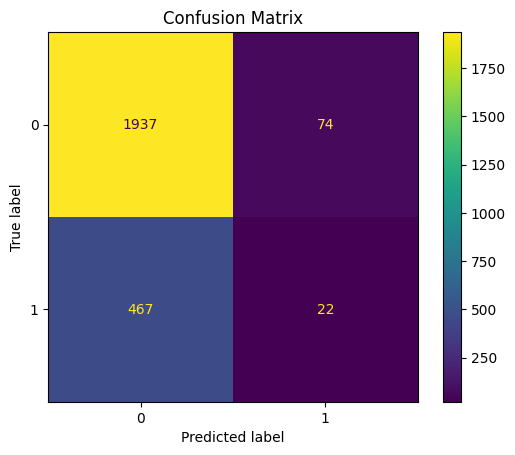

In [6]:
%pip install matplotlib --quiet

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = pipeline.predict(XTest)

cm = confusion_matrix(yTest, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [7]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'Dropout_Likelihood' is your target variable column
class_counts = df['Dropout_Likelihood'].value_counts()

print(class_counts)

Dropout_Likelihood
0    8043
1    1957
Name: count, dtype: int64


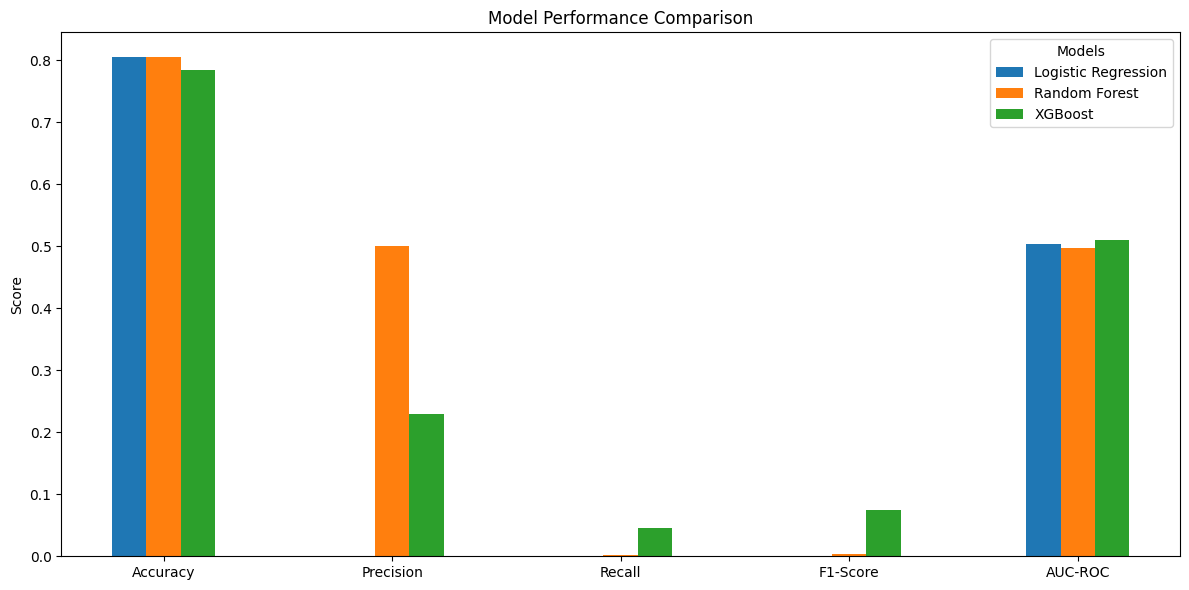

In [8]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
model_names = list(resultsDf.index)

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
x_positions = np.arange(len(metrics))

for i, model in enumerate(model_names):
    ax.bar(x_positions + i * bar_width, resultsDf.loc[model, metrics], bar_width, label=model)

ax.set_xticks(x_positions + bar_width * (len(model_names) - 1) / 2)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend(title='Models')

plt.tight_layout()
plt.show()


In [13]:
import joblib

custom_path = '../models/'  # Specify your custom path here
best_model_name = bestF1Model
best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', models[best_model_name])
])
best_model_pipeline.fit(XTrain, yTrain)

file_name = f'{custom_path}best_model_{best_model_name.replace(" ", "_")}.joblib'
joblib.dump(best_model_pipeline, file_name)
print(f"\nSaved best model to: {file_name}")



Saved best model to: ../models/best_model_XGBoost.joblib


d:\EvolveEd\envi\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:08:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
